In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
from scipy.optimize import minimize
import concurrent.futures
import time

import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from likelihood import process_agent

In [12]:
BETA_MULTIPLIER = 20

N_TEST_AGENT = 500
num_blocks = 12
num_trials_per_block = 6*13
beta_multipliers = 20
task = 'rlf_6s3a'
suffix = '3ParamRL_no_switch_st55' #''2ParamRL_no_switch' #'
prefix = f'{N_TEST_AGENT}a_{num_blocks}b_{num_trials_per_block}t_{suffix}'
data = pd.read_csv(f'data/{task}/{N_TEST_AGENT}a_{num_blocks}b_{num_trials_per_block}t_{suffix}.csv')

# Run Optimizer

In [13]:
from scipy.optimize import minimize
from concurrent.futures import ProcessPoolExecutor
import time

# Main execution
start_time = time.time()

metadata_by_task = {
    'rls':  {
        'param_names': ['alpha', 'beta', 'stickiness'], 
        'bounds': [(0.2, 0.8), (0.2, 0.8), (-1, 1)],
        'multipliers': np.array([1, beta_multipliers, 1]),
    },
    'rlsf':  {
        'param_names': ['alpha', 'beta', 'stickiness', 'phi'],
        'bounds': [(0.2, 0.8), (0.2, 0.8), (-1, 1), (0, 1)],
        'multipliers': np.array([1, beta_multipliers, 1, 1]),
    },
    'shared': {
        'param_names': ['alpha0', 'alpha1', 'beta'],
        'bounds': [(0.01, 1), (0.01, 1), (0.01, 1)],
        'multipliers': np.array([1, 1, 10]),
    },
}

metadata = metadata_by_task['rlsf']

# Get unique agent IDs (limit to 200 if needed)
limit = 500
agent_ids = data.agentid.unique()
agent_ids = agent_ids[:limit]

est_params = []
max_workers = 5
# Run the optimization in parallel
with ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks
    future_to_aid = {
        executor.submit(process_agent, aid, data, metadata): aid
        for aid in agent_ids
    }

    # Process results as they complete
    results = {}
    for future in concurrent.futures.as_completed(future_to_aid):
        aid = future_to_aid[future]
        try:
            agent_id, params = future.result()
            if params is not None:
                results[agent_id] = params
        except Exception as e:
            print(f'Agent {aid} generated an exception: {str(e)}')

# Convert results to the same format as before
est_params = [results[aid] for aid in sorted(results.keys()) if aid in results]

print(f'Total agents processed: {len(est_params)}')
est_params = np.array(est_params)

# Build the dataframe
recovered_param = {}
for idx, pn in enumerate(metadata['param_names']):
    recovered_param[pn] = est_params[:, idx]

recovered_param = pd.DataFrame(recovered_param)

# Print timing information
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

Starting optimization for agent 0...
Starting optimization for agent 1...
Starting optimization for agent 2...
Starting optimization for agent 3...
Starting optimization for agent 4...
Completed optimization for agent 2
Completed optimization for agent 1
Starting optimization for agent 5...
Starting optimization for agent 6...
Completed optimization for agent 0
Starting optimization for agent 7...
Completed optimization for agent 4
Starting optimization for agent 8...
Completed optimization for agent 5
Starting optimization for agent 9...
Completed optimization for agent 3
Starting optimization for agent 10...
Completed optimization for agent 7
Starting optimization for agent 11...
Completed optimization for agent 8
Starting optimization for agent 12...
Completed optimization for agent 6
Starting optimization for agent 13...
Completed optimization for agent 9
Starting optimization for agent 14...
Completed optimization for agent 10
Starting optimization for agent 15...
Completed optimi

# Eval

Text(0.5, 1.01, 'MLE')

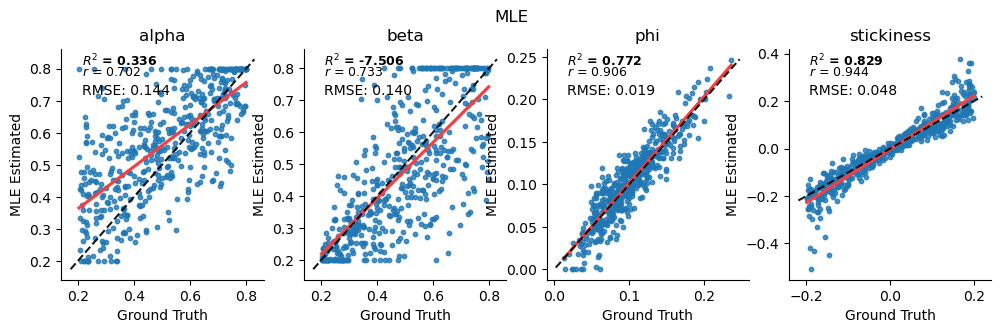

In [19]:
# @title model parameters
from utils.feature_utils import get_condition_aware_labels
from utils.evaluation_utils import add_corr_scores
from sklearn.metrics import mean_squared_error  

recovered_param = recovered_param.rename(columns={"nalpha": "neg_alpha"})
param_names = list(recovered_param.keys())

if task != 'shared':
  shared, conditioned = metadata['param_names'], []
else:
  shared, conditioned = ['beta'], ['alpha']

n_cols = len(param_names)
true_name_labels = get_condition_aware_labels(data[data.agentid < limit], shared, conditioned)

fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(3*n_cols, 3))
for idx, pn in enumerate(sorted(param_names)):
  y_true = true_name_labels[pn].ravel()
  y_pred = recovered_param[pn]

  result = pd.DataFrame({pn: y_true/metadata['multipliers'][idx], 'mle': y_pred})
  ax = sns.regplot(
      data=result, ci=None, x=pn, y='mle', line_kws=dict(color="#f73e40"), scatter_kws=dict(s=10), ax=axes.flat[idx],
  )
  ax.plot(
      [ax.get_xlim()[0], ax.get_xlim()[1]],
      [ax.get_xlim()[0], ax.get_xlim()[1]],
      color="black",
      alpha=0.9,
      linestyle="dashed",
  )
  sns.despine()

  ax = add_corr_scores(ax, y_true, y_pred)

  mse = mean_squared_error(y_true/metadata['multipliers'][idx], y_pred, squared=False)
  ax.text(0.1, 0.8, f"RMSE: {mse:.3f}", transform=ax.transAxes, fontsize=10)
  ax.set_xlabel('Ground Truth')
  ax.set_ylabel('MLE Estimated')
  ax.set_title(pn, fontsize=12)

fig.suptitle('MLE', y=1.01)

In [15]:
prefix = f'{N_TEST_AGENT}a_{num_blocks}b_{num_trials_per_block}t_{suffix}'
recovered_param.to_csv(f'results/mle_{task}_{prefix}_constrained.csv')

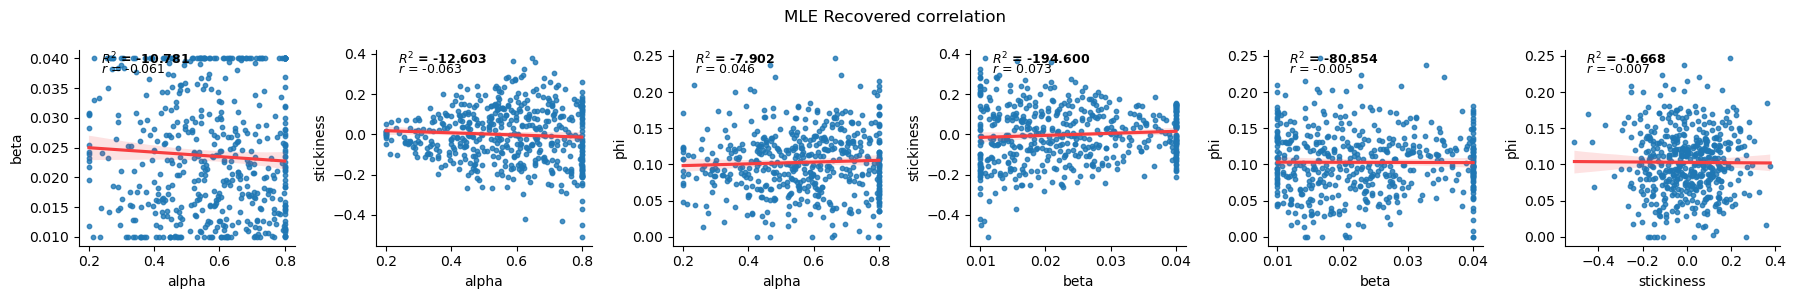

In [18]:
param_names = metadata['param_names']
n_col = len(param_names)+2
fig, axes = plt.subplots(1, n_col, figsize=(3*n_col, 3))
multipliers = {p: metadata['multipliers'][i] for i, p in enumerate(param_names)}
ai = 0
flatted_axes = axes.flatten()
for i, pn1 in enumerate(param_names):
    for j, pn2 in enumerate(param_names[i+1:]):
        y_true, y_pred = recovered_param[pn1]/multipliers[pn1], recovered_param[pn2]/multipliers[pn2]
        ax = flatted_axes[ai]
        sns.regplot(x=y_true, y=y_pred, ax=ax, line_kws=dict(color="#f73e40"), scatter_kws=dict(s=10))
        ax = add_corr_scores(ax, y_true, y_pred)
        ax.set_xlabel(pn1)
        ax.set_ylabel(pn2)
        ai += 1

sns.despine()
fig.suptitle('MLE Recovered correlation')
fig.tight_layout()